In [74]:
from data_cleaning import clean_dataframe, append_msrp, append_retains_value, get_expected_value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [115]:
# Cleaning takes ~20mins, so we try to avoid repeating it
try:
    df = pd.read_csv("true_car_cleaned.csv", index_col=0)
except FileNotFoundError:
    # source: https://www.kaggle.com/datasets/harikrishnareddyb/used-car-price-predictions
    df = pd.read_csv("true_car_listings.csv")
    df = clean_dataframe(df)
    df = append_msrp(df)
    df = append_retains_value(df)
    df = df.dropna()

In [89]:
# Correlation Matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Price,Year,Mileage,MSRP,expected_value,retains_value
Price,1.000000,0.419120,-0.431040,0.656896,0.811262,0.386196
Year,0.419120,1.000000,-0.770829,0.016519,0.521414,0.008011
Mileage,-0.431040,-0.770829,1.000000,-0.039812,-0.435089,-0.151765
MSRP,0.656896,0.016519,-0.039812,1.000000,0.812103,-0.010448
expected_value,0.811262,0.521414,-0.435089,0.812103,1.000000,0.004994
retains_value,0.386196,0.008011,-0.151765,-0.010448,0.004994,1.000000


We see the variable that will eventually become our class, `retains_value`, has very little correlation to `MSRP` and `Mileage`. This may suggest more of a connection between Make, Model, and specific model-years (since they aren't featured in this numerical-only matrix).

`expected_value` is strongly correlated to `Price`, meaning on average our metric of depreciation mostly holds true. However, with this machine learning model we hope to further granularize this and give a better understanding of how different features affect how value is held (or not held).

<AxesSubplot:>

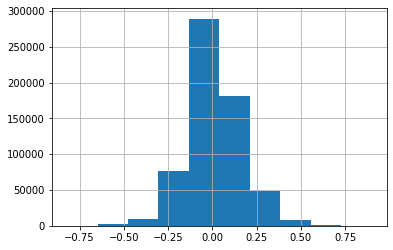

In [114]:
# Distribution of price differences
df.apply(lambda x: (x['Price'] - x['expected_value']) / (x['Price'] + x['expected_value']), axis=1).hist()

In [96]:
# we should drop `Price`, since our model should neither know it nor predict it
df = df[['Year', 'Mileage', 'Make', 'Model', 'MSRP', 'retains_value']]
df['retains_value'].value_counts()

True     309529
False    308233
Name: retains_value, dtype: int64

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree


X = df.drop('retains_value', axis=1)
y = df['retains_value']

numeric_features = ['Year', 'Mileage', 'MSRP']
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_features = ['Make', 'Model']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
])
# classifier = LinearSVC(verbose=1, dual=False)
# classifier = SVC(verbose=1, kernel='linear')


In [102]:
classifier = tree.DecisionTreeClassifier(min_impurity_decrease=0.0002)

clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.758039060160417


### Testing hyperparameters:

```
min_impurity_decrease=0
0.7268
min_impurity_decrease=0.0001
0.76915
min_impurity_decrease=0.001
0.69285
min_impurity_decrease=0.01
0.55105
min_impurity_decrease=0.1
0.50345
```

min_impurity_decrease=0.0
0.7286427686903596
min_impurity_decrease=5.2631578947368424e-05
0.7800215292222771
min_impurity_decrease=0.00010526315789473685
0.7692245433133958
min_impurity_decrease=0.00015789473684210527
0.7633728035741747
min_impurity_decrease=0.0002105263157894737
0.7555057343811967
min_impurity_decrease=0.0002631578947368421
0.7485613461429508
min_impurity_decrease=0.00031578947368421053
0.7425315451668515
min_impurity_decrease=0.00036842105263157896
0.7403948103243143
min_impurity_decrease=0.0004210526315789474
0.7335475463970927
min_impurity_decrease=0.0004736842105263158
0.7270078427881153
min_impurity_decrease=0.0005263157894736842
0.7204843265643084
min_impurity_decrease=0.0005789473684210527
0.7161380136459657
min_impurity_decrease=0.0006315789473684211
0.7152315200764044
min_impurity_decrease=0.0006842105263157895
0.711573171027818
min_impurity_decrease=0.0007368421052631579
0.6986556376615704
min_impurity_decrease=0.0007894736842105264
0.6955962218643011
min_im

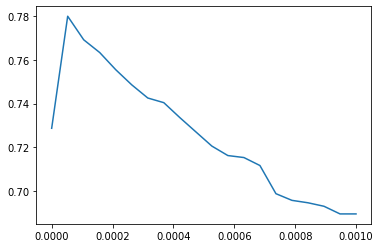

In [84]:
params = [0, 0.0001, 0.001, 0.01, 0.1]
params = np.linspace(0, 0.001, 20)
scores = []
for param in params:
    print(f"min_impurity_decrease={param}")
    classifier = tree.DecisionTreeClassifier(min_impurity_decrease=param)

    clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(score)
    scores.append(score)

plt.plot(params, scores)

In [ ]:
plt.figure(dpi=1000)
tree.plot_tree(clf['classifier'], class_names=True)

![Tree Plot looks REALLY good](plot_tree.png "Tree Plot looks REALLY good")

Area under the Receiver Operating Characteristic curve: 0.8362622558020619


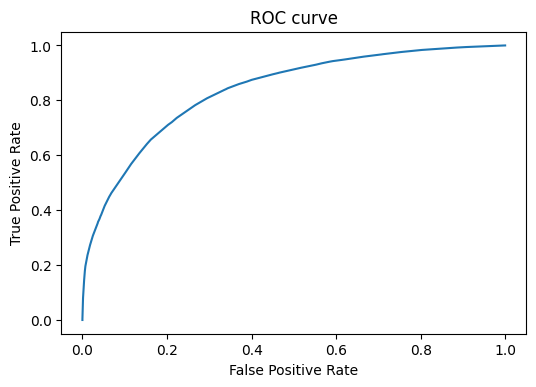

In [106]:
# adapted from @gbhand's D6
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

scores = clf.predict_proba(X_test)[:,1]
fps = []
tps = []
for threshold in np.linspace(0,1,1000):
    y_pred = scores > threshold
    true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, y_pred).ravel()
    fps.append(false_positives / (false_positives + true_negatives)) # add false positive rate
    tps.append(true_positives / (true_positives + false_negatives)) # add true positive rate

fpr = fps
tpr = tps

roc_auc = roc_auc_score(y_test, scores)

# plotting the ROC curve
plt.figure(dpi=100)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Area under the Receiver Operating Characteristic curve:', roc_auc)